# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter 
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_rows, azdias_columns = azdias.shape[0], azdias.shape[1]
print("{} rows and {} columns in the 'Udacity_AZDIAS_Subset.csv' file.".format(azdias_rows, azdias_columns))
print("The first 5 rows:")
print(azdias.head(5))

891221 rows and 85 columns in the 'Udacity_AZDIAS_Subset.csv' file.
The first 5 rows:
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0               

In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
missing_count_dict = dict()
for column in azdias.columns:
    missing_values = feat_info[feat_info['attribute'] == column]['missing_or_unknown']
    missing_values = missing_values.values[0].split(']')[0].split('[')[1]
    
    if ','in missing_values:
        missing_values = missing_values.split(',')
    else:
        missing_values = [str(missing_values)]
    missing_count = 0
    if missing_values !=['']:
        for missing_value in missing_values:
            if 'X' not in missing_value:
                missing_count += (azdias[column] == int(missing_value)).sum()
                azdias.loc[azdias[column] == int(missing_value), column] = np.NaN
            else:
                missing_count += (azdias[column] == (missing_value)).sum()
                azdias.loc[azdias[column] == missing_value, column] = np.NaN
                
    missing_count_dict[column] = missing_count
print(missing_count_dict)

{'AGER_TYP': 685843, 'ALTERSKATEGORIE_GROB': 2881, 'ANREDE_KZ': 0, 'CJT_GESAMTTYP': 0, 'FINANZ_MINIMALIST': 0, 'FINANZ_SPARER': 0, 'FINANZ_VORSORGER': 0, 'FINANZ_ANLEGER': 0, 'FINANZ_UNAUFFAELLIGER': 0, 'FINANZ_HAUSBAUER': 0, 'FINANZTYP': 0, 'GEBURTSJAHR': 392318, 'GFK_URLAUBERTYP': 0, 'GREEN_AVANTGARDE': 0, 'HEALTH_TYP': 111196, 'LP_LEBENSPHASE_FEIN': 92778, 'LP_LEBENSPHASE_GROB': 89718, 'LP_FAMILIE_FEIN': 72938, 'LP_FAMILIE_GROB': 72938, 'LP_STATUS_FEIN': 0, 'LP_STATUS_GROB': 0, 'NATIONALITAET_KZ': 108315, 'PRAEGENDE_JUGENDJAHRE': 108164, 'RETOURTYP_BK_S': 0, 'SEMIO_SOZ': 0, 'SEMIO_FAM': 0, 'SEMIO_REL': 0, 'SEMIO_MAT': 0, 'SEMIO_VERT': 0, 'SEMIO_LUST': 0, 'SEMIO_ERL': 0, 'SEMIO_KULT': 0, 'SEMIO_RAT': 0, 'SEMIO_KRIT': 0, 'SEMIO_DOM': 0, 'SEMIO_KAEM': 0, 'SEMIO_PFLICHT': 0, 'SEMIO_TRADV': 0, 'SHOPPER_TYP': 111196, 'SOHO_KZ': 0, 'TITEL_KZ': 815562, 'VERS_TYP': 111196, 'ZABEOTYP': 0, 'ALTER_HH': 236768, 'ANZ_PERSONEN': 0, 'ANZ_TITEL': 0, 'HH_EINKOMMEN_SCORE': 0, 'KK_KUNDENTYP': 0, 'W_KEI

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

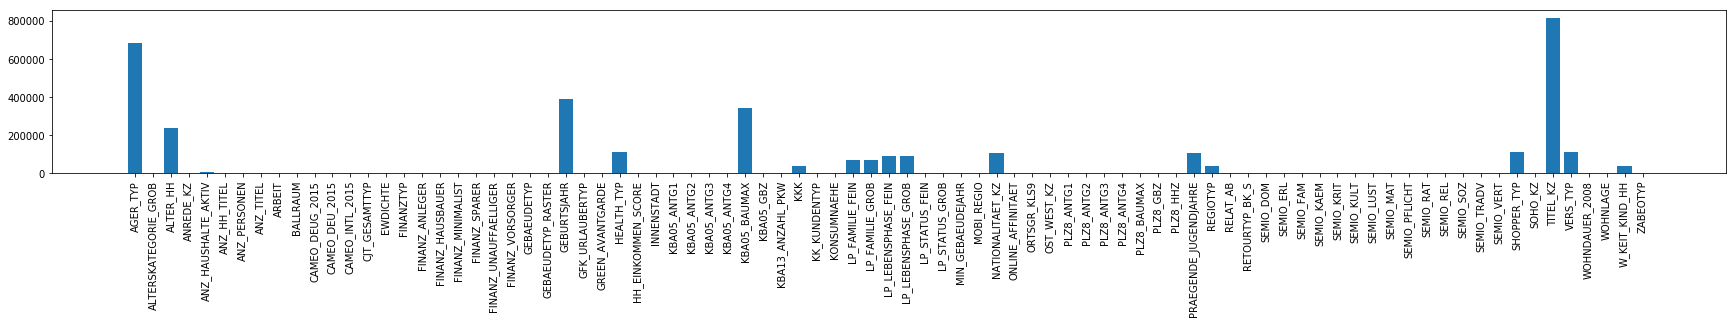

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
f = plt.figure(figsize=(30,3))
plt.bar(list(missing_count_dict.keys()), list(missing_count_dict.values()))
plt.xticks(rotation=90);

In [8]:
# Investigate patterns in the amount of missing data in each column.
sorted_missing_value = sorted(missing_count_dict.items(), key=lambda kv: kv[1], reverse=True)
most_missing_columns = list()
for i in range(len(sorted_missing_value)):
    if sorted_missing_value[i][1]/azdias_rows > 0:
        most_missing_columns.append(sorted_missing_value[i][0])
        print('{:.3f}% of data is missing in column {}'.format(sorted_missing_value[i][1]/azdias_rows*100., sorted_missing_value[i][0]))

91.511% of data is missing in column TITEL_KZ
76.955% of data is missing in column AGER_TYP
44.020% of data is missing in column GEBURTSJAHR
38.509% of data is missing in column KBA05_BAUMAX
26.567% of data is missing in column ALTER_HH
12.477% of data is missing in column HEALTH_TYP
12.477% of data is missing in column SHOPPER_TYP
12.477% of data is missing in column VERS_TYP
12.154% of data is missing in column NATIONALITAET_KZ
12.137% of data is missing in column PRAEGENDE_JUGENDJAHRE
10.410% of data is missing in column LP_LEBENSPHASE_FEIN
10.067% of data is missing in column LP_LEBENSPHASE_GROB
8.184% of data is missing in column LP_FAMILIE_FEIN
8.184% of data is missing in column LP_FAMILIE_GROB
4.532% of data is missing in column W_KEIT_KIND_HH
4.137% of data is missing in column KKK
4.137% of data is missing in column REGIOTYP
0.725% of data is missing in column ANZ_HAUSHALTE_AKTIV
0.323% of data is missing in column ALTERSKATEGORIE_GROB
0.042% of data is missing in column CAME

In [9]:
info_level = Counter()
data_type = Counter()

for column in most_missing_columns:
    # print(feat_info[feat_info['attribute'] == column]['information_level'])
    info = feat_info.loc[feat_info['attribute'] == column]['information_level'].values[0]
    info_level[info] += 1
    data = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
    data_type[data] += 1
print(info_level)
print(data_type)


Counter({'person': 13, 'microcell_rr4': 3, 'community': 3, 'household': 2, 'region_rr1': 2, 'microcell_rr3': 1, 'building': 1})
Counter({'categorical': 9, 'ordinal': 8, 'mixed': 5, 'numeric': 2, 'interval': 1})


In [10]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias.drop(['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'ALTER_HH'], axis=1, inplace=True)
azdias.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'KK_KUNDENTYP', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'CAMEO_DE

#### Discussion 1.1.2: Assess Missing Data in Each Column

There are missing data in columns: TITEL_KZ, AGER_TYP, GEBURTSJAHR, KBA05_BAUMAX, ALTER_HH, HEALTH_TYP, SHOPPER_TYP, VERS_TYP, NATIONALITAET_KZ, PRAEGENDE_JUGENDJAHRE, LP_LEBENSPHASE_FEIN, LP_LEBENSPHASE_GROB, LP_FAMILIE_FEIN, LP_FAMILIE_GROB, W_KEIT_KIND_HH, KKK, REGIOTYP, ANZ_HAUSHALTE_AKTIV, ALTERSKATEGORIE_GROB, CAMEO_DEUG_2015, CAMEO_DEU_2015, CAMEO_INTL_2015, ARBEIT, RELAT_AB, ORTSGR_KLS9. Amongst these columns, there 13 of them are person level information. And 3 of them are microcell_rr4 and community level data, 2 of them are household level and region_rr1, and 1 of them are microcell_rr3 and building level data. So it seems that this dataset has lots of personal information missing. <br>
The top 5 most missing data colums are: <br>
91.5% of data is missing in column TITEL_KZ <br>
77.0% of data is missing in column AGER_TYP <br>
44.0% of data is missing in column GEBURTSJAHR <br>
38.5% of data is missing in column KBA05_BAUMAX <br>
26.6% of data is missing in column ALTER_HH <br>
These columns have more than 20% are missing. Amongst these 5 columns, the top 3 columns TITEL_KZ, AGER_TYP, GEBURTSJAHR are all person level data.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [11]:
# How much data is missing in each row of the dataset?
missing_counts_row = list()
missing_row_index = list()
threshold = 20
total = 0
under_thres = 0
above_thres = 0
for index, row in azdias.iterrows():
    if row.isnull().sum() > 0:
        total += 1
        missing_counts_row.append(row.isnull().sum())
        if row.isnull().sum() > threshold:
            under_thres += 1
            missing_row_index.append(index)
print('rows with missing data {}, rows with more than {} missing data {}'.format(total, threshold, under_thres))

rows with missing data 650736, rows with more than 20 missing data 94042


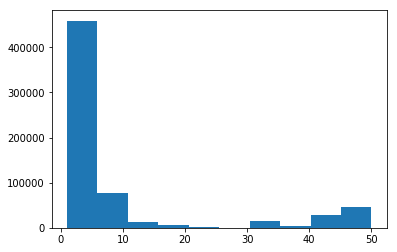

In [12]:
plt.hist(missing_counts_row);

The above figure is a histogram of missing value counts in each row. Most rows have less than 10 missing values, so the threshold is set to 10.

In [13]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
azdias_above = azdias.loc[missing_row_index, :]
azdias_under = azdias.drop(missing_row_index)

In [14]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_column(column):
    plt.subplot(211)
    ax = sns.countplot(x=column, data=azdias_above)
    ax.set_title('subset with more than 10 missing values in each row')
    plt.subplot(212)
    ax1 = sns.countplot(x=column, data=azdias_under)
    ax1.set_title('subset with less than 10 missing values in each row')

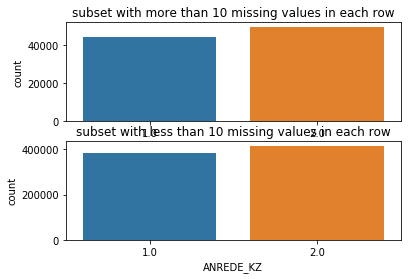

In [15]:
compare_column('ANREDE_KZ')

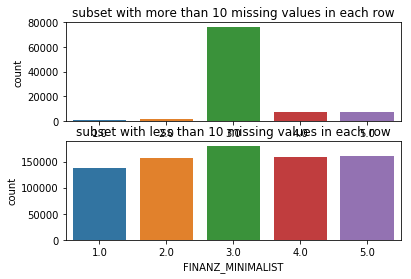

In [16]:
compare_column('FINANZ_MINIMALIST')

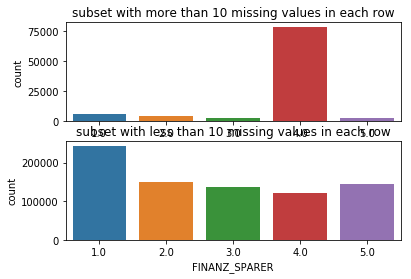

In [17]:
compare_column('FINANZ_SPARER')

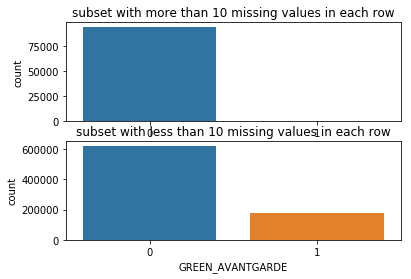

In [18]:
compare_column('GREEN_AVANTGARDE')

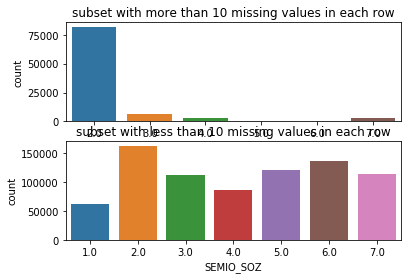

In [19]:
compare_column('SEMIO_SOZ')

#### Discussion 1.1.3: Assess Missing Data in Each Row

There are a total of 650736 rows that have missing data. According to the missing counte per row histogram, rows with more than 20 values missing are treated as outliers. And there are 94042 rows that have more than 20 missing data per row. Then the data is divided into 2 subsets, one with nomissing values per row, and the other with missing values per row. By plotting the distributions of the values in the same column for both datasets, it turns out the distributions look quite differently in these two datasets.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [20]:
# How many features are there of each data type?
all_data_type = Counter()
for column in azdias.columns:
    # print(feat_info[feat_info['attribute'] == column]['information_level'])
    data = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
    all_data_type[data] += 1
print(all_data_type)

Counter({'ordinal': 49, 'categorical': 19, 'mixed': 6, 'numeric': 6})


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [21]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
multilevel_columns = list()
categorical_columns = list()
for column in azdias.columns:

    column_type = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
    if column_type == 'categorical':
        categorical_columns.append(column)
        if len(azdias_under[column].unique()) > 3:
            multilevel_columns.append(column)
        if len(azdias_under[column].unique()) == 3 and pd.isnull(azdias_under[column].unique()).sum() == 0:
            multilevel_columns.append(column)

In [22]:
# CAMEO_DEU_2015 has non-numerical values in it, convert them to number
for i, value in enumerate(azdias_under.loc[azdias_under['CAMEO_DEU_2015'].notnull(), 'CAMEO_DEU_2015'].unique()):
    azdias_under.loc[azdias_under['CAMEO_DEU_2015'] == value, 'CAMEO_DEU_2015'] = i

In [23]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Feature 'OST_WEST_KZ' is one binary variable that takes on non-numeric values. 
# This one will be re-encoded as numbers.
azdias_under.loc[azdias_under['OST_WEST_KZ'] == 'W', 'OST_WEST_KZ'] = 0
azdias_under.loc[azdias_under['OST_WEST_KZ'] == 'O', 'OST_WEST_KZ'] = 1

In [24]:
# fill the missing values of the categorical data with the most frequent value
for column in categorical_columns:
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    azdias_under[column] = imp.fit_transform(azdias_under[column].values.reshape(-1, 1))

In [25]:
# Multi-level categoricals will be encoded with dummy variables and retain the missing values as nans
def convert_multilevel(df, column):
    df1 = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    df1.loc[df[column].isnull(), df1.columns.str.startswith(column)] = np.nan
    column_nan = column + '_nan'
    df1.drop([column_nan], axis=1, inplace=True)
    df = pd.concat([df, df1],axis=1)

    df.drop([column],axis=1, inplace=True)
    return df


In [26]:
# Multi-level categoricals will be encoded with dummy variables and retain the missing values as nans
for column in multilevel_columns:
    print(column)
    azdias_under = convert_multilevel(azdias_under, column)

CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


The values in column CAMEO_DEU_2015 are encoded to numerical number in order to perform imputation. The missing values in all the categorical columns are filled with the most frequent value in that column. Columns 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', and 'OST_WEST_KZ' are binary categorical data. Only 'OST_WEST_KZ' contains non-numerical values 'W' and 'O', and 'W' is encoded to 0 and 'O' is encoded to 1. The multi-level categorical columns are 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'KK_KUNDENTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'. These columns are encoded with dummy variables, and the new columns with the original column name as predix are added to the dataframe. The original column is dropped afterward.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
Avantgarde = [2., 4., 6., 7., 9., 11., 13., 15.]
Mainstream = [1., 3., 5., 8., 10., 12., 14.]
def movement_to_categorical(x):
    if x in Avantgarde:
        return 0
    if x in Mainstream:
        return 1
    else:
        return np.nan
def decade_to_categorical(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 8:
        return 2
    elif x < 10:
        return 3
    elif x < 16:
        return 4
    else:
        return np.nan

In [28]:
azdias_under['movement'] = azdias_under['PRAEGENDE_JUGENDJAHRE'].apply(movement_to_categorical)
azdias_under['decade'] = azdias_under['PRAEGENDE_JUGENDJAHRE'].apply(decade_to_categorical)

In [29]:
 
imp = Imputer(missing_values='NaN', strategy='median', axis=0)
azdias_under['decade'] = imp.fit_transform(azdias_under['decade'].values.reshape(-1, 1))
imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
azdias_under['movement'] = imp.fit_transform(azdias_under['movement'].values.reshape(-1, 1))

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new ordinal variables .
def convert_CAMEO_INTL_2015(df, column):
    df['wealth'] = df['CAMEO_INTL_2015'].apply(lambda x: x[0] if isinstance(x, str) else np.nan)
    df['life'] = df['CAMEO_INTL_2015'].apply(lambda x: x[1] if isinstance(x, str) else np.nan)
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    df['wealth'] = imp.fit_transform(df['wealth'].values.reshape(-1, 1))
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    df['life'] = imp.fit_transform(df['life'].values.reshape(-1, 1))
    return df

azdias_under = convert_CAMEO_INTL_2015(azdias_under, 'CAMEO_INTL_2015')

In [31]:
azdias_under.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)
- "PRAEGENDE_JUGENDJAHRE" is divided into 2 features: decade and movement (mainstream vs. avantgarde). Decade is a interval-type variable, whenre 40s is mapped to 0, 50s to 1, 60s to 2, 70s to 3, 80s to 4 and 90s to 5. Movement is a binary variable, where 0 means avantgarde and 1 means mainstream.
- "CAMEO_INTL_2015" is divided into two new ordinal variables: wealth(the 'tens'-place) and life stage(the 'ones'-place digits). 
- all the other multi-level categorical data is transformed to interval type variables
- the missing values in categorical columns are encoded with the most frequent value in the columns; the missing values in ordinal columns are encoded with the median value; the missing value in numerical columns are encoded with the average value.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [32]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# For ordinal type columns, fill the missing value with median. For the numerical type columns, fill the missing value with mean.
for column in azdias.columns:
    if column not in categorical_columns and column in azdias_under.columns:
        data = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
        if data =='ordinal':
            imp = Imputer(missing_values='NaN', strategy='median', axis=0)
            azdias_under[column] = imp.fit_transform(azdias_under[column].values.reshape(-1, 1))
        if data =='numerical':
            imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
            azdias_under[column] = imp.fit_transform(azdias_under[column].values.reshape(-1, 1))
        else:
            azdias_under.drop([column], axis=1, inplace=True) 


All the missing values are encoded with the strategy mentioned above. The mixed type data is dropped, since the other columns have the same information.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [33]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    for column in df.columns:
        missing_values = feat_info[feat_info['attribute'] == column]['missing_or_unknown']
        missing_values = missing_values.values[0].split(']')[0].split('[')[1]

        if ','in missing_values:
            missing_values = missing_values.split(',')
        else:
            missing_values = [str(missing_values)]

        if missing_values !=['']:
            for missing_value in missing_values:
                if 'X' not in missing_value:
                    df.loc[df[column] == int(missing_value), column] = np.NaN
                else:
                    df.loc[df[column] == missing_value, column] = np.NaN
        
    # remove selected columns and rows, ...
    # remove selected columns
    df.drop(['AGER_TYP', 'TITEL_KZ', 'GEBURTSJAHR', 'KBA05_BAUMAX', 'ALTER_HH'], axis=1, inplace=True)
    
    # assess missing values in rows
    missing_index = list()
    threshold = 20
    total = 0
    under_thres = 0
    for index, row in df.iterrows():
        if row.isnull().sum() > 0:
            total += 1
            if row.isnull().sum() > threshold:
                under_thres += 1
                missing_index.append(index)
    print('rows with missing data {}, rows with more than {} missing data {}'.format(total, threshold, under_thres))
        
    # Write code to divide the data into two subsets based on the number of missing values in each row.
    df_above = df.loc[missing_index, :]
    df_under = df.drop(missing_index)
    
    # select, re-encode, and engineer column values.
    # Assess categorical variables: which are binary, which are multi-level, and
    # which one needs to be re-encoded?
    multilevel_columns = list()
    categorical_columns = list()
    for column in df.columns:
        column_type = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
        if column_type == 'categorical':
            categorical_columns.append(column)
            if len(df_under[column].unique()) > 3:
                multilevel_columns.append(column)
            if len(df_under[column].unique()) == 3 and pd.isnull(df_under[column].unique()).sum() == 0:
                multilevel_columns.append(column)
                
    # CAMEO_DEU_2015 has non-numerical values in it, convert them to number
    # CAMEO_DEU_2015 has non-numerical values in it, convert them to number
    for i, value in enumerate(df_under.loc[df_under['CAMEO_DEU_2015'].notnull(), 'CAMEO_DEU_2015'].unique()):
        df_under.loc[df_under['CAMEO_DEU_2015'] == value, 'CAMEO_DEU_2015'] = i

    # Re-encode categorical variable(s) to be kept in the analysis.
    # Feature 'OST_WEST_KZ' is one binary variable that takes on non-numeric values. 
    # This one will be re-encoded as numbers.
    df_under.loc[df_under['OST_WEST_KZ'] == 'W', 'OST_WEST_KZ'] = 0
    df_under.loc[df_under['OST_WEST_KZ'] == 'O', 'OST_WEST_KZ'] = 1
    
    # fill the missing values of the categorical data with the most frequent value
    for column in categorical_columns:
        imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
        df_under[column] = imp.fit_transform(df_under[column].values.reshape(-1, 1))
    
    # get_dummies for multi-level categorical data
    for column in multilevel_columns:
        print(column)
        df_under = convert_multilevel(df_under, column)
   
    # Re-encode categorical variable(s) to be kept in the analysis.
    # Feature 'OST_WEST_KZ' is one binary variable that takes on non-numeric values. 
    # This one will be re-encoded as numbers.
    df_under['movement'] = df_under['PRAEGENDE_JUGENDJAHRE'].apply(movement_to_categorical)
    df_under['decade'] = df_under['PRAEGENDE_JUGENDJAHRE'].apply(decade_to_categorical)
    imp = Imputer(missing_values='NaN', strategy='median', axis=0)
    df_under['decade'] = imp.fit_transform(df_under['decade'].values.reshape(-1, 1))
    imp = Imputer(missing_values='NaN', strategy='most_frequent', axis=0)
    df_under['movement'] = imp.fit_transform(df_under['movement'].values.reshape(-1, 1))
    
    df_under = convert_CAMEO_INTL_2015(df_under, 'CAMEO_INTL_2015')
    df_under.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015'], axis=1, inplace=True)
    
    # For ordinal type columns, fill the missing value with median. For the numerical type columns, fill the missing value with mean.
    for column in df.columns:
        if column not in categorical_columns and column in df_under.columns:
            data = feat_info.loc[feat_info['attribute'] == column]['type'].values[0]
            if data =='ordinal':
                imp = Imputer(missing_values='NaN', strategy='median', axis=0)
                df_under[column] = imp.fit_transform(df_under[column].values.reshape(-1, 1))
            if data =='numerical':
                imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
                df_under[column] = imp.fit_transform(df_under[column].values.reshape(-1, 1))
            else:
                df_under.drop([column], axis=1, inplace=True) 

    for column in azdias_under.columns:
        if column not in df.columns:
            df_under[column] = 0
    # Return the cleaned dataframe.

    return df_under, df_above

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [34]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias_under.isnull().sum()

ANREDE_KZ               0
GREEN_AVANTGARDE        0
SOHO_KZ                 0
VERS_TYP                0
OST_WEST_KZ             0
CJT_GESAMTTYP_1.0       0
CJT_GESAMTTYP_2.0       0
CJT_GESAMTTYP_3.0       0
CJT_GESAMTTYP_4.0       0
CJT_GESAMTTYP_5.0       0
CJT_GESAMTTYP_6.0       0
FINANZTYP_1.0           0
FINANZTYP_2.0           0
FINANZTYP_3.0           0
FINANZTYP_4.0           0
FINANZTYP_5.0           0
FINANZTYP_6.0           0
GFK_URLAUBERTYP_1.0     0
GFK_URLAUBERTYP_2.0     0
GFK_URLAUBERTYP_3.0     0
GFK_URLAUBERTYP_4.0     0
GFK_URLAUBERTYP_5.0     0
GFK_URLAUBERTYP_6.0     0
GFK_URLAUBERTYP_7.0     0
GFK_URLAUBERTYP_8.0     0
GFK_URLAUBERTYP_9.0     0
GFK_URLAUBERTYP_10.0    0
GFK_URLAUBERTYP_11.0    0
GFK_URLAUBERTYP_12.0    0
LP_FAMILIE_FEIN_1.0     0
                       ..
CAMEO_DEU_2015_18.0     0
CAMEO_DEU_2015_19.0     0
CAMEO_DEU_2015_20.0     0
CAMEO_DEU_2015_21.0     0
CAMEO_DEU_2015_22.0     0
CAMEO_DEU_2015_23.0     0
CAMEO_DEU_2015_24.0     0
CAMEO_DEU_20

In [35]:
# Apply feature scaling to the general population demographics data.
azidas_under_scale = StandardScaler().fit_transform(azdias_under)

### Discussion 2.1: Apply Feature Scaling

 StandardScaler() function is used to transform the general demographic dataset, which has less missing values. All columns are transformed to values with mean of 0 and standard deviation of 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [36]:
# Apply PCA with half the number of features to the data.
pca = PCA(n_components = int(azdias_under.shape[1])) #
X_pca = pca.fit_transform(azidas_under_scale)

Component    Explained_variance_ratio
    0                4.97%
    1                3.01%
    2                2.47%
    3                2.11%
    4                1.89%
    5                1.78%
    6                1.66%
    7                1.62%
    8                1.55%
    9                1.53%
    10                1.52%
    11                1.49%
    12                1.47%
    13                1.46%
    14                1.43%
    15                1.37%
    16                1.33%
    17                1.27%
    18                1.21%
    19                1.18%
    20                1.09%
    21                1.05%
    22                1.03%
    23                1.01%
    24                0.98%
    25                0.93%
    26                0.93%
    27                0.87%
    28                0.86%
    29                0.85%
    30                0.85%
    31                0.83%
    32                0.82%
    33                0.81%
    34              

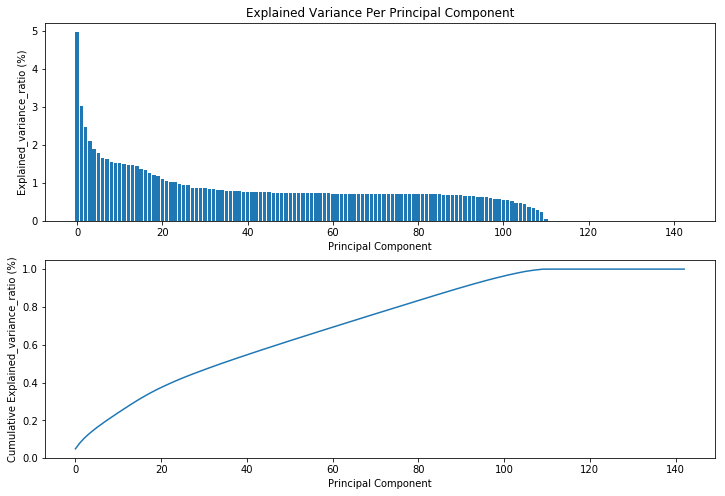

In [37]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    print('Component    Explained_variance_ratio')
    for i in range(num_components):
        print('    {}                {:.2f}%'.format(i, vals[i]*100))
          
    plt.figure(figsize=(12, 8))
    ax = plt.subplot(211)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals*100)
    
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Explained_variance_ratio (%)")
    plt.title('Explained Variance Per Principal Component')
    
    ax = plt.subplot(212)
    ax.plot(ind, cumvals)
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Cumulative Explained_variance_ratio (%)")

scree_plot(pca)


In [38]:
# Re-apply PCA to the data while selecting for number of components to retain.
def do_pca(n_components, X):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [39]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca, X_pca = do_pca(23, azidas_under_scale)

### Discussion 2.2: Perform Dimensionality Reduction
 
The scree plot shows the elbow appears around 23. So 23 principle component is choosen for the next step of analysis.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [40]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# get all PCA components
components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_under.keys())
components.index = dimensions


In [41]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def sort_weight(components, dimension):
    column_name = 'd_' + str(dimension)
    df = pd.DataFrame({column_name: components.iloc[dimension-1]})
    return df.sort_values(by=[column_name])

sort_weight(components, 1)

,d_1
wealth,-0.2863
LP_STATUS_GROB_1.0,-0.2770
movement,-0.2309
LP_STATUS_FEIN_1.0,-0.1971
LP_FAMILIE_GROB_1.0,-0.1948
LP_FAMILIE_FEIN_1.0,-0.1948
CAMEO_DEUG_2015_9.0,-0.1647
LP_STATUS_FEIN_2.0,-0.1413
FINANZTYP_1.0,-0.1353
CAMEO_DEUG_2015_8.0,-0.1330


In [42]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sort_weight(components, 2)

,d_2
ZABEOTYP_3.0,-0.3092
CJT_GESAMTTYP_2.0,-0.2036
LP_FAMILIE_GROB_1.0,-0.2000
LP_FAMILIE_FEIN_1.0,-0.2000
KK_KUNDENTYP_3.0,-0.1836
FINANZTYP_2.0,-0.1648
FINANZTYP_5.0,-0.1485
NATIONALITAET_KZ_1.0,-0.1448
CJT_GESAMTTYP_1.0,-0.1243
life,-0.0973


In [43]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
sort_weight(components, 3)

,d_3
LP_STATUS_GROB_4.0,-0.4020
LP_STATUS_FEIN_9.0,-0.3867
movement,-0.3288
GEBAEUDETYP_1.0,-0.1338
CAMEO_DEUG_2015_4.0,-0.1239
CAMEO_DEUG_2015_3.0,-0.1229
FINANZTYP_6.0,-0.1093
LP_STATUS_FEIN_8.0,-0.0892
LP_STATUS_FEIN_4.0,-0.0888
CAMEO_DEU_2015_5.0,-0.0846


### Discussion 2.3: Interpret Principal Components

For the first principle component, the most important negative features are wealth, LP_STATUS_GROB_1.0 and movement, ant the most important positive features are LP_STATUS_GROB_5.0, LP_STATUS_FEIN_10.0 and GREEN_AVANTGARDE. Wealth, LP_STATUS_GROB, and LP_STATUS_FEIN are all features related to how wealth and income of family. Since wealth is encoded as the wealthier the lower categorical number, and LP_STATUS_GROB and  LP_STATUS_FEIN are encoded in the opposite direction, so they have different sign. GREEN_AVANTGARDE and (LP_STATUS_GROB, LP_STATUS_FEIN) have the same sign, which means that wealthier person or family tends to be a member in environmental sustainability. The movement feature and GREEN_AVANTGARDE both mean if a person is avantgarde or not. As they are encoded oppositely, so they have different sign.<br>
 For the first principle component, the most important negative features are ZABEOTYP_3.0, CJT_GESAMTTYP_2.0 and LP_FAMILIE_GROB_1.0, ant the most important positive features are FINANZTYP_1.0, ZABEOTYP_4.0 and decade. The CJT_GESAMTTYP and decade have different sign, which means the older people have less buying channels, and are more of a traditional kind shopper. Also the ZABEOTYP and decade have a negative relationship, it seems like the older generation has more conservative energy comsumption style. The FINANZTYP, decade, and ZABEOTYP have a positive relation, means that older people are more like money-savers.<br>
 The third principle component has the the almost same most important features as the first principle component, except it doesn't include wealth in it. The variation in wealth are mostly explained in the first principle component.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [44]:
# Over a number of different cluster counts...
def do_kmeans(n_clusters, X):
    # run k-means clustering on the data and...
    model = KMeans(n_clusters=n_clusters)
    model.fit(X)
    
    # compute the average within-cluster distances.
    score = -model.score(X)
    return model, score

2 clusters, score 40441158.305
3 clusters, score 38024971.378
4 clusters, score 36057492.357
5 clusters, score 34327974.025
6 clusters, score 33443820.823
7 clusters, score 31872388.420
8 clusters, score 30525387.855
9 clusters, score 29457126.994
10 clusters, score 27572661.118
11 clusters, score 26770805.839
12 clusters, score 25871081.373
13 clusters, score 25882858.911
14 clusters, score 24559802.525
15 clusters, score 24854307.312
16 clusters, score 23952600.778
17 clusters, score 23593664.026
18 clusters, score 23284596.525
19 clusters, score 22964719.651
20 clusters, score 22634605.253
21 clusters, score 22535332.310
22 clusters, score 22165170.680
23 clusters, score 21995030.391
24 clusters, score 21784956.185
25 clusters, score 21585982.434
26 clusters, score 21402946.031
27 clusters, score 21213416.270
28 clusters, score 20938453.601
29 clusters, score 20795742.860
30 clusters, score 20592449.692
31 clusters, score 20336057.642
32 clusters, score 20279862.882
33 clusters, sco

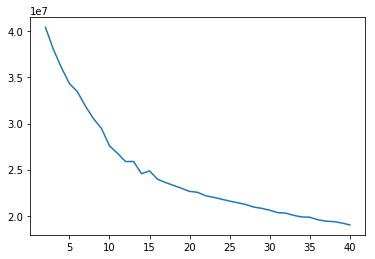

In [45]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
ks = [i+1 for i in range(1,40)]
scores = list()
for k in ks:
    _, score = do_kmeans(k, X_pca)
    scores.append(score)
    print('{} clusters, score {:.3f}'.format(k, score))
plt.plot(ks, scores)

In [46]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
cluster_model, score = do_kmeans(15, X_pca)

In [47]:
general_labels = cluster_model.fit_predict(X_pca)

In [48]:
general_with_predicted_labels = pd.concat([azdias_under, pd.DataFrame(general_labels,columns = ['plabels'])],axis=1)

### Discussion 3.1: Apply Clustering to General Population

According to the scree plot, 15 appears to the the elbow point. 15 clusters will be used in the following analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [49]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [50]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers, above_customers = clean_data(customers)

rows with missing data 126707, rows with more than 20 missing data 50042
CJT_GESAMTTYP
FINANZTYP
GFK_URLAUBERTYP
LP_FAMILIE_FEIN
LP_FAMILIE_GROB
LP_STATUS_FEIN
LP_STATUS_GROB
NATIONALITAET_KZ
SHOPPER_TYP
ZABEOTYP
KK_KUNDENTYP
GEBAEUDETYP
CAMEO_DEUG_2015
CAMEO_DEU_2015


In [51]:
clean_customers_scale = StandardScaler().fit_transform(clean_customers)
X_pca_customers = pca.transform(clean_customers_scale)
customers_labels = cluster_model.fit_predict(X_pca_customers)

In [52]:
customers_with_predicted_labels = pd.concat([clean_customers, pd.DataFrame(customers_labels,columns = ['plabels'])],axis=1)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

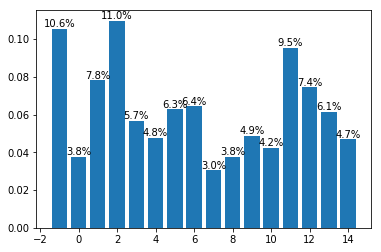

In [53]:
counter_p = Counter()

for i in general_labels:
    counter_p[i] += 1
counter_p[-1] = azdias_above.shape[0]
total = 0
for i in counter_p:
    total += counter_p[i]
for i in counter_p:
    counter_p[i] /= total
bar1 = plt.bar(counter_p.keys(), counter_p.values())
for rect in bar1:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}%'.format(height*100), ha='center', va='bottom')

50042


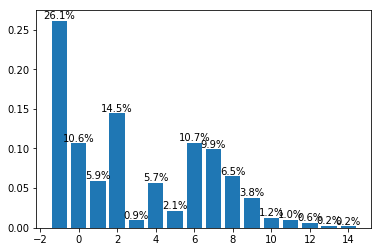

In [54]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
counter_c = Counter()

for i in customers_labels:
    counter_c[i] += 1
counter_c[-1] = above_customers.shape[0]
total = 0
for i in counter_c:
    total += counter_c[i]
print(counter_c[-1])
for i in counter_c:
    counter_c[i] /= total
bar2 = plt.bar(counter_c.keys(), counter_c.values())
for rect in bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '{:.1f}%'.format(height*100), ha='center', va='bottom')

In [55]:
def get_centroid(pca, model, label, df):
    inverse_centroid = pca.inverse_transform(model.cluster_centers_[label])
    return inverse_centroid

In [58]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
c7 = get_centroid(pca, cluster_model, 7, clean_customers)
for column, c in zip(clean_customers.columns,c7):
    print(column, c)

ANREDE_KZ -0.259784882986
GREEN_AVANTGARDE -0.176770658961
SOHO_KZ -0.0228758413548
VERS_TYP 0.101394497388
OST_WEST_KZ -0.0518112828879
CJT_GESAMTTYP_1.0 0.0498761102655
CJT_GESAMTTYP_2.0 -0.0723600585441
CJT_GESAMTTYP_3.0 0.030554948355
CJT_GESAMTTYP_4.0 -0.0174616215408
CJT_GESAMTTYP_5.0 0.0585869716233
CJT_GESAMTTYP_6.0 -0.0387428690003
FINANZTYP_1.0 -0.00162798884134
FINANZTYP_2.0 -0.0639938785292
FINANZTYP_3.0 -0.0189166768333
FINANZTYP_4.0 0.0201552315699
FINANZTYP_5.0 0.146469040188
FINANZTYP_6.0 -0.0587980517798
GFK_URLAUBERTYP_1.0 0.00412042670499
GFK_URLAUBERTYP_2.0 -0.0291230620882
GFK_URLAUBERTYP_3.0 -0.013820116165
GFK_URLAUBERTYP_4.0 0.0401287559803
GFK_URLAUBERTYP_5.0 -0.00258540357533
GFK_URLAUBERTYP_6.0 0.0145957764457
GFK_URLAUBERTYP_7.0 -0.0317204760934
GFK_URLAUBERTYP_8.0 -0.00041107947053
GFK_URLAUBERTYP_9.0 0.0262506424976
GFK_URLAUBERTYP_10.0 0.0366546053769
GFK_URLAUBERTYP_11.0 -0.0345192273794
GFK_URLAUBERTYP_12.0 -0.0140481209974
LP_FAMILIE_FEIN_1.0 0.0068096

In [57]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
c12 = get_centroid(pca, cluster_model, 12, clean_customers)
for column, c in zip(clean_customers.columns,c12):
    print(column, c)

ANREDE_KZ 0.39597420617
GREEN_AVANTGARDE 0.0670184416362
SOHO_KZ 0.0598446483201
VERS_TYP -0.103597589118
OST_WEST_KZ 0.85769758247
CJT_GESAMTTYP_1.0 -0.0987430727534
CJT_GESAMTTYP_2.0 0.201417639716
CJT_GESAMTTYP_3.0 -0.148668400225
CJT_GESAMTTYP_4.0 0.060208666994
CJT_GESAMTTYP_5.0 -0.00160917639732
CJT_GESAMTTYP_6.0 -0.0393976713614
FINANZTYP_1.0 -0.147643718707
FINANZTYP_2.0 -0.0796279918245
FINANZTYP_3.0 -0.215092592906
FINANZTYP_4.0 -0.054491776339
FINANZTYP_5.0 -0.621805642876
FINANZTYP_6.0 0.759732467067
GFK_URLAUBERTYP_1.0 -0.0757326145195
GFK_URLAUBERTYP_2.0 0.00651914857642
GFK_URLAUBERTYP_3.0 -0.0695921902671
GFK_URLAUBERTYP_4.0 -0.162667568025
GFK_URLAUBERTYP_5.0 0.135145546475
GFK_URLAUBERTYP_6.0 -0.0411976436145
GFK_URLAUBERTYP_7.0 0.0834278559747
GFK_URLAUBERTYP_8.0 -0.0495661831266
GFK_URLAUBERTYP_9.0 0.086450616175
GFK_URLAUBERTYP_10.0 -0.254630602713
GFK_URLAUBERTYP_11.0 0.0288086710801
GFK_URLAUBERTYP_12.0 0.260815185026
LP_FAMILIE_FEIN_1.0 -0.0497584036345
LP_FAMIL

### Discussion 3.3: Compare Customer Data to Demographics Data


Label 7 cluster is overrepresented. 9.9% of persons are assigned to a cluster for the customers data, but 3.0% of the general population data is closest to that cluster's centroid. That suggests the people in that cluster to be a target audience for the company. According to the centroid values, this group tends to be male, not a member of green avantgarde, houseowners, insurance type:individualistic-accepting risks, shopper type external supplied hedonists or shopping-stressed, social status: houseowners, financial type:investor ,and the dominating movement of person's youth happens at later decade. <br>
Label 12 cluster is underrepresented. 0.6% of persons are assigned to a cluster for the general population, but 7.4% of the customer data is closest to that cluster's centroid. These group tends to have the features like, female, insurance type:social-safety driven, building location: East, financial type:inconspicuous, shopper type: demanding shopper, Social status:villagers or top-earner, vacaiton type: nature fan or without vacation. People who have these features are more unpopular to the company.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.